# Classification of molecules by aqueous solubility
Here we try to answer some of the following questions from the original notebook on Classification of molecules by aqueous solubility:
    


    1) The  𝑘 -nearest neighbors method depends on one crucial hyperparameter:  𝑘 . How does the number of neighbors impact the model? What happens for very small and very large values of  𝑘 ? For this data set, what is the value that provides the best accuracy?
    2) Another family of classification algorithms are decision trees. They are relatively easy to understand and interpret. Can you train a decision tree for this task? How does the accuracy compare with other models? Does an ensemble method (like a random forest) perform better than a single decision tree?
    3) How do the models produced for the “small” (highly accurate) data set and “big” data set compare? Can we make statistical comparisons between the values present in both data sets?
    4) We have set up our problem as a classification task by defining cut-off values of solubility for soluble and insoluble molecules. Could we, as an alternative, use the same solubility data to create a regression task? How would the resulting predictions compare?
 

This notebook was inspired by Pat Walters: https://github.com/PatWalters/chem_tutorial/blob/main/tutorial_03_eda.ipynb

## Importing the libraries:

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Machine learning
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
set_config(display='diagram')

## Load Data From CSV File

First we examine the dataset to see how many records (molecules) it contains and what information is present for each molecule.

In [2]:
df = pd.read_csv("curated-solubility-dataset.csv")

In [3]:
print('Number of records:', len(df))
print('Number of columns:', len(df.keys()))
print('Overview of the first records:')
df.head()

Number of records: 9982
Number of columns: 26
Overview of the first records:


,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934


In [4]:
df.describe()

,Solubility,SD,Ocurrences,MolWt,MolLogP,MolMR,HeavyAtomCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
count,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000
mean,-2.889909,0.067449,1.378081,266.665946,1.979167,66.794594,17.374674,3.486776,1.108595,5.196955,4.073031,94.243438,1.068323,0.292627,0.447606,1.515929,62.458601,108.912586,2.392199,467.336782
std,2.368154,0.234702,1.023476,184.179024,3.517738,46.523021,12.241536,3.498203,1.488973,4.736275,5.646925,64.748563,1.309427,0.879599,1.054667,1.644334,63.348307,76.462726,1.091123,546.631696
min,-13.171900,0.000000,1.000000,9.012000,-40.873200,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.504228,-0.000004,0.000000
25%,-4.326325,0.000000,1.000000,162.276000,0.619750,40.602475,11.000000,2.000000,0.000000,3.000000,1.000000,58.000000,0.000000,0.000000,0.000000,0.000000,26.300000,66.623721,2.004357,163.243343
50%,-2.618173,0.000000,1.000000,228.682000,1.949220,58.633400,15.000000,3.000000,1.000000,4.000000,3.000000,82.000000,1.000000,0.000000,0.000000,1.000000,50.720000,93.299873,2.539539,351.640433
75%,-1.209735,0.000000,1.000000,320.436000,3.419030,81.938000,21.000000,4.000000,2.000000,6.000000,5.000000,112.000000,2.000000,0.000000,1.000000,2.000000,80.390000,129.118374,3.032456,606.562848
max,2.137682,3.870145,38.000000,5299.456000,68.541140,1419.351700,388.000000,86.000000,26.000000,89.000000,141.000000,2012.000000,35.000000,30.000000,30.000000,36.000000,1214.340000,2230.685124,7.517310,20720.267708


## Data visualization and pre-processing

For a start we will work with G3 and G5 groups that contain the most reliable data.

In [5]:
df = df[df['Group'].isin(['G3', 'G5', 'G2', 'G4', 'G1'])]
print('Number of records in df:', len(df))

Number of records in df: 9982


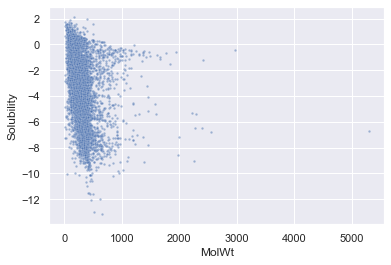

In [6]:
_ = sns.scatterplot(data=df, x='MolWt', y='Solubility', s=6, alpha=0.5)

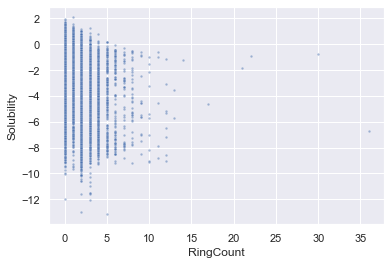

In [7]:
_ = sns.scatterplot(data=df, x='RingCount', y='Solubility', s=6, alpha=0.5)

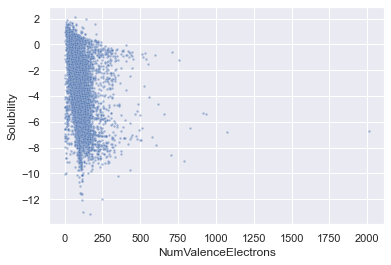

In [8]:
_ = sns.scatterplot(data=df, x='NumValenceElectrons', y='Solubility', s=6, alpha=0.5)

## Setting up a classification problem

We want to create a classification model that will predict if a molecule is soluble or not. Thus we have two discrete labels or categories: soluble and insoluble.

We therefore start by creating these categories. We define a molecule as soluble in water if its solubility is higher than 200 μM.

In [9]:
def isSoluble(s):
    return 'yes' if s > np.log10(200e-6) else 'no'

df['Soluble'] = df['Solubility'].apply(isSoluble)
df.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT,Soluble
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334,yes
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248,yes
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065,yes
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666,no
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934,no


Having modified the whole dataset df, we need to extract again our restricted dataset of high accuracy data df1.

In [10]:
df1 = df[df['Group'].isin(['G3', 'G5'])]

In [11]:
df1['Soluble'].value_counts()

yes    1260
no      558
Name: Soluble, dtype: int64

We can have a look at the distribution of the solubility values in the data set:

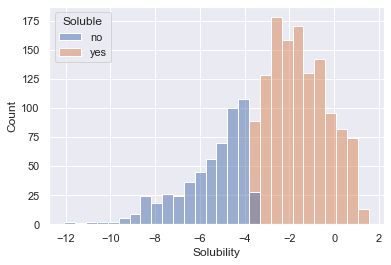

In [12]:
_ = sns.histplot(data=df1, x='Solubility', hue='Soluble')

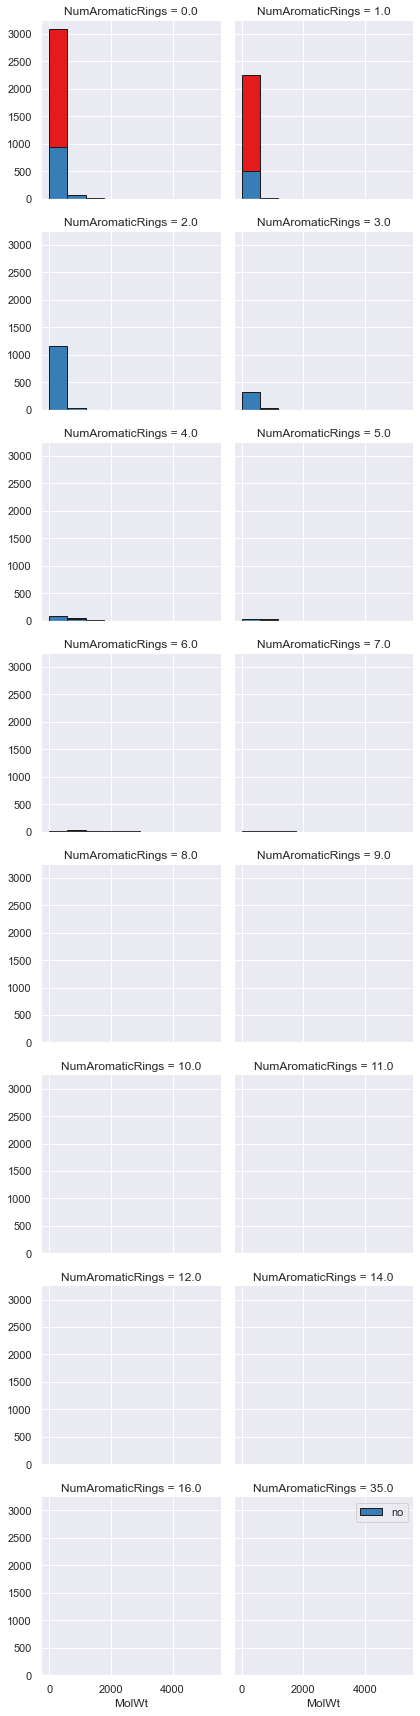

In [13]:
bins = np.linspace(df.MolWt.min(), df.MolWt.max(), 10)
g = sns.FacetGrid(df, col="NumAromaticRings", hue="Soluble", palette="Set1", col_wrap=2)
g.map(plt.hist, 'MolWt', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

In [14]:
df['Rings'] = df['NumAromaticRings'].apply(lambda x: 1 if (x<3)  else 0)
df.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT,Soluble,Rings
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334,yes,1
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248,yes,1
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065,yes,1
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666,no,0
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934,no,1


In [15]:
df.groupby(['NumAromaticRings'])['Soluble'].value_counts(normalize=True)

NumAromaticRings  Soluble
0.0               yes        0.753936
                  no         0.246064
1.0               yes        0.813223
                  no         0.186777
2.0               no         0.537171
                  yes        0.462829
3.0               no         0.652087
                  yes        0.347913
4.0               no         0.624339
                  yes        0.375661
5.0               no         0.611111
                  yes        0.388889
6.0               yes        0.559322
                  no         0.440678
7.0               no         0.545455
                  yes        0.454545
8.0               no         0.700000
                  yes        0.300000
9.0               no         0.750000
                  yes        0.250000
10.0              yes        1.000000
11.0              no         0.750000
                  yes        0.250000
12.0              no         1.000000
14.0              yes        1.000000
16.0              no    

In [16]:
df.groupby(['NumSaturatedRings'])['Soluble'].value_counts(normalize=True)

NumSaturatedRings  Soluble
0.0                yes        0.678264
                   no         0.321736
1.0                yes        0.718412
                   no         0.281588
2.0                yes        0.608553
                   no         0.391447
3.0                no         0.559809
                   yes        0.440191
4.0                no         0.637500
                   yes        0.362500
5.0                no         0.583333
                   yes        0.416667
6.0                no         0.500000
                   yes        0.500000
7.0                no         0.500000
                   yes        0.500000
8.0                no         1.000000
10.0               yes        1.000000
13.0               no         1.000000
21.0               yes        1.000000
22.0               yes        1.000000
30.0               yes        1.000000
Name: Soluble, dtype: float64

## Feature Selection

In order to choose descriptors that are the best suited for predicting solubility, we will make a function that will train a model for each descriptor, and give us as a result the accuracy measured on the test dataset. We will start with the kNN model. 

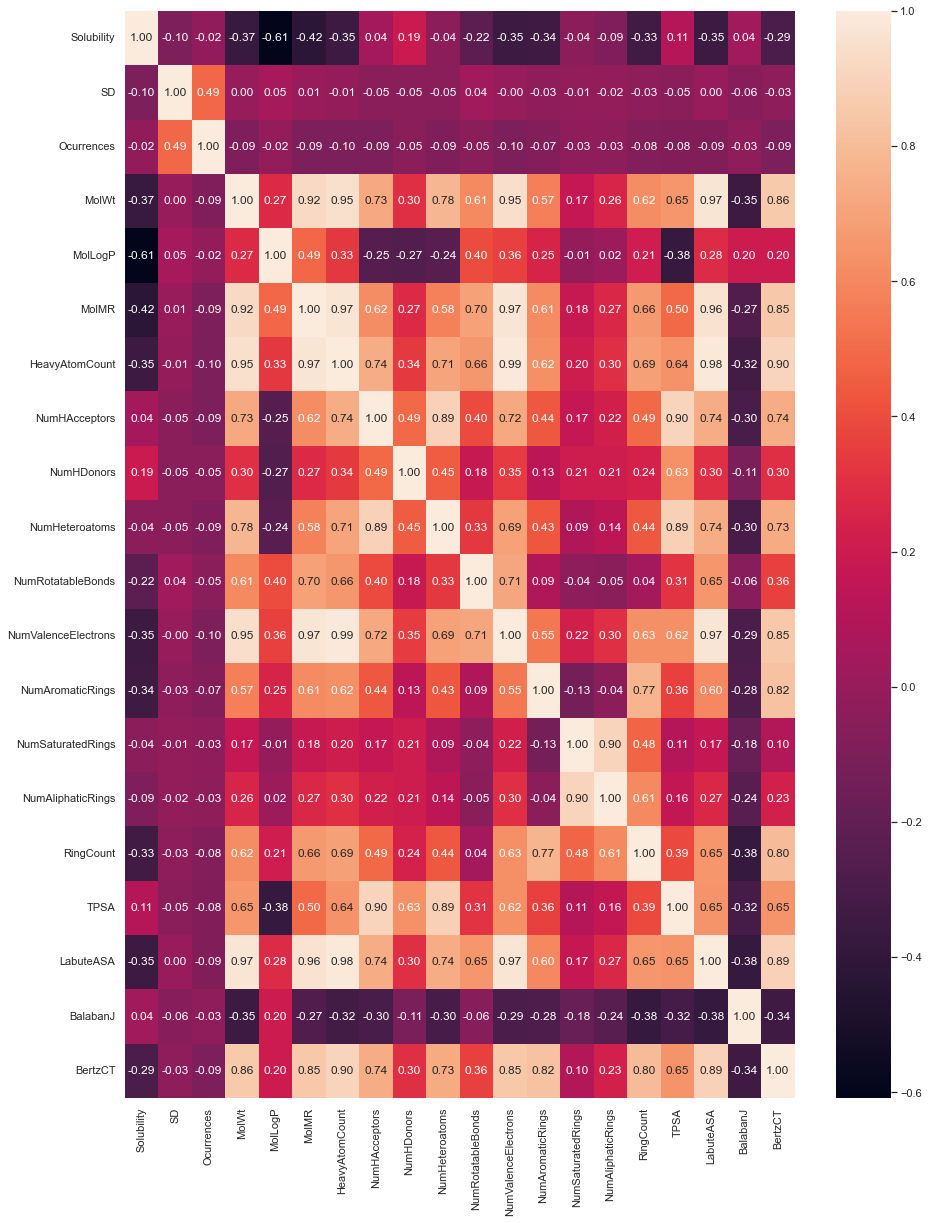

In [17]:
##Correlation

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt


def plot_correlation(data):
    '''
    plot correlation's matrix to explore dependency between features 
    '''
    # init figure size
    rcParams['figure.figsize'] = 15, 20
    fig = plt.figure()
    sns.heatmap(data.corr(), annot=True, fmt=".2f")
    plt.show()
    fig.savefig('corr.png')

# load your data 
data  = pd.read_csv("curated-solubility-dataset.csv")

# plot correlation & densities
plot_correlation(data)

From now on we will work with the following ansamble of the descriptors:

In [18]:
Feature = df[['MolLogP', 'MolMR', 'MolWt', 'HeavyAtomCount',
              'NumValenceElectrons', 'NumAromaticRings', 'RingCount',
  'LabuteASA' ]]

Feature.head()

,MolLogP,MolMR,MolWt,HeavyAtomCount,NumValenceElectrons,NumAromaticRings,RingCount,LabuteASA
0,3.9581,102.4454,392.510,23.0,142.0,0.0,0.0,158.520601
1,2.4055,51.9012,169.183,13.0,62.0,2.0,3.0,75.183563
2,2.1525,36.8395,140.569,9.0,46.0,1.0,1.0,58.261134
3,8.1161,200.7106,756.226,53.0,264.0,6.0,6.0,323.755434
4,2.4854,119.0760,422.525,31.0,164.0,2.0,6.0,183.183268


In [19]:
train, test = train_test_split(df, random_state=42)
print('Records in training data:', len(train))
print('Records in testing data:', len(test))

Records in training data: 7486
Records in testing data: 2496


Removing the correlated descriptors

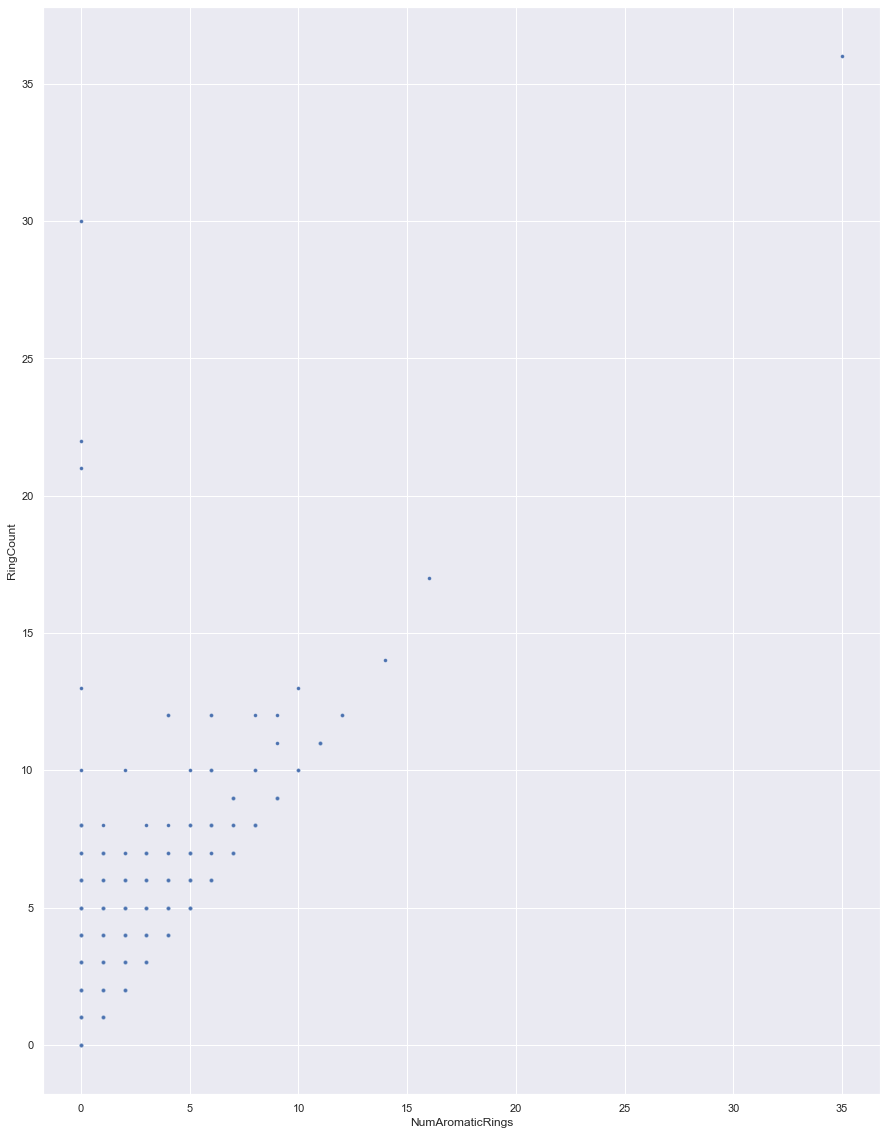

In [20]:
_ = sns.scatterplot(data=df, x='NumAromaticRings', y='RingCount', s=15, alpha=1)

We are going to train different types of models for this classification task. 

In [21]:
X_train = train[['MolLogP', 'MolMR', 'MolWt', 'HeavyAtomCount',
              'NumValenceElectrons', 'NumAromaticRings',
  'LabuteASA']]
X_test = test[['MolLogP', 'MolMR', 'MolWt', 'HeavyAtomCount',
              'NumValenceElectrons', 'NumAromaticRings',
  'LabuteASA']]

y_train = train['Soluble']
y_test = test['Soluble']


# kNN

Neighbors-based classification is a type of instance-based learning: it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point. Here we will use the most common technique -  KNeighborsClassifier. 

The optimal choice of the value  is highly data-dependent. In the case of a small number of neighbors, the noise will have a higher influence on the result. Larger number suppresses the effects of noise, but makes the classification boundaries less distinct and is computationally expensive. Research has also shown that a small number of neighbors are the most flexible fit which will have low bias but high variance and a large number of neighbors will have a smoother decision boundary which means lower variance but higher bias.


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

train, test = train_test_split(df, random_state=42)
from sklearn import metrics
from sklearn.metrics import jaccard_score

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for k in range(1, Ks):
    KNN = KNeighborsClassifier(n_neighbors=3).fit(X_train.values, y_train.values)
    yhat = KNN.predict(X_test.values)
    mean_acc[k-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[k-1] = np.std(yhat==y_test) / np.sqrt(yhat.shape[0])
    
mean_acc

array([0.83653846, 0.83653846, 0.83653846, 0.83653846, 0.83653846,
       0.83653846, 0.83653846, 0.83653846, 0.83653846])

## Optimal K

   A heuristic rule suggests that optimal k should be close to the square root of sample number. However, this may not be true in our case, since the number of descriptors is much smaller then the number of samples. Thus, in order to find k that provides the best accuracy, we built a kNN model with k values ranging from 1 to 50 and chose the one with the best accuracy.

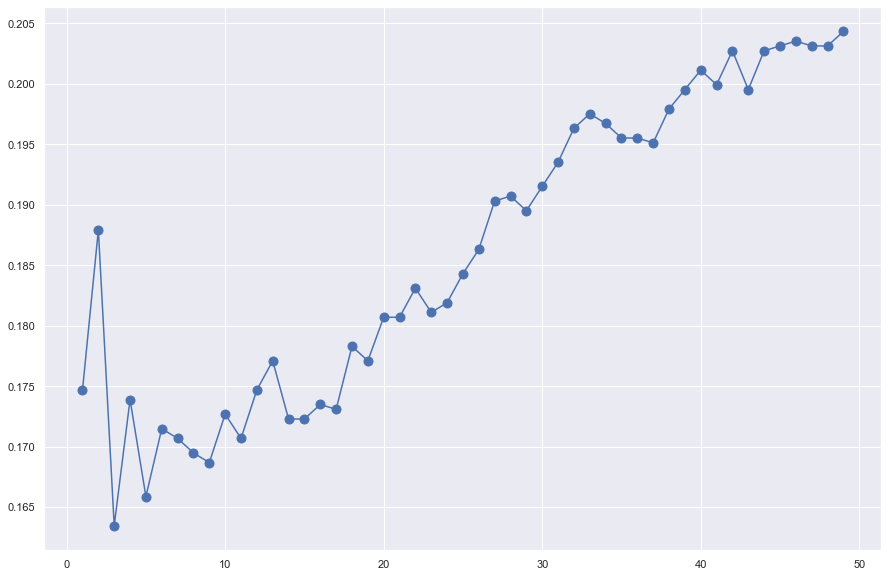

In [23]:
#k = sqrt(1818)/2 = 21
error_rate = []

for i in range(1,50):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train.values, y_train)
    pred = knn.predict(X_test.values)
    error_rate.append(np.mean(pred != y_test))

plt.figure(figsize=(15,10))
plt.plot(range(1,50),error_rate, marker='o', markersize=9)

In [24]:
K = 5
KNN = KNeighborsClassifier(n_neighbors=5).fit(X_train.values, y_train)

In [25]:
#evaluation
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [26]:
KNN_yhat = KNN.predict(X_test.values) 

jaccard_KNN = jaccard_score(y_test, KNN_yhat, pos_label='yes')
print('Jaccard score of the K-Nearest Neighbor: ', jaccard_KNN)

f1_KNN = f1_score(y_test, KNN_yhat, pos_label='yes')
print('f1 score of the K-Nearest Neighbor: ', f1_KNN)

Jaccard score of the K-Nearest Neighbor:  0.78060413354531
f1 score of the K-Nearest Neighbor:  0.8767857142857143


# Decision tree model

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 

Add sth about the max depth

In [27]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df1, random_state=42)
X_train = train[['MolLogP', 'MolMR', 'MolWt', 'HeavyAtomCount',
              'NumValenceElectrons', 'NumAromaticRings',
  'LabuteASA']]
X_test = test[['MolLogP', 'MolMR', 'MolWt', 'HeavyAtomCount',
              'NumValenceElectrons', 'NumAromaticRings', 
  'LabuteASA']]

y_train = train['Soluble']
y_test = test['Soluble']

In [28]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=6)
tree.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=6)

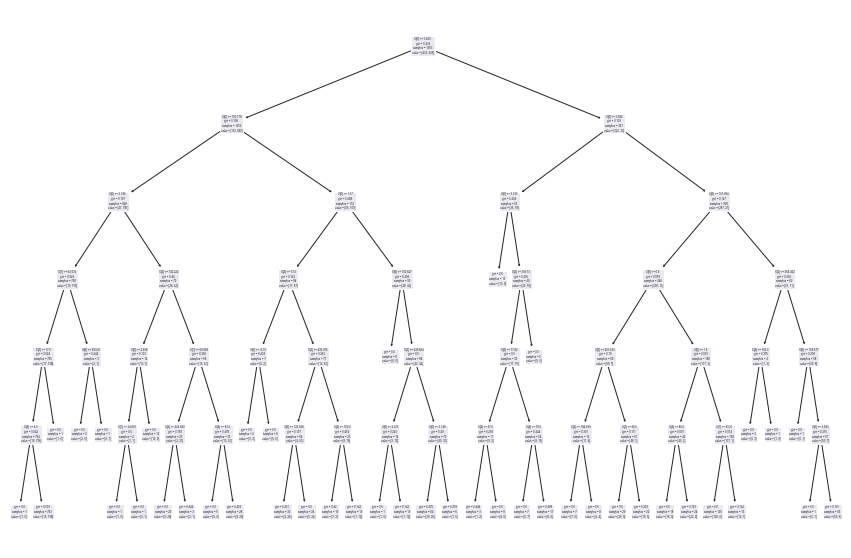

In [29]:
from sklearn.tree import plot_tree

_, ax = plt.subplots(figsize=(15, 10))
_ = plot_tree(tree, ax=ax)

Add sth about the tree not being balalnced

In [30]:
test_score = tree.fit(X_train, y_train).score(X_test, y_test)
print(f"Accuracy of the DecisionTreeClassifier: {test_score:.2f}")

Accuracy of the DecisionTreeClassifier: 0.87


In [31]:
tree_yhat = tree.predict(X_test) 

jaccard_tree = jaccard_score(y_test, tree_yhat, pos_label='yes')
print('Jaccard score of the Decision Tree Classifier: ', jaccard_tree)

f1_tree = f1_score(y_test, tree_yhat, pos_label='yes')
print('f1 score of the Decision Tree Classifier: ', f1_tree)

Jaccard score of the Decision Tree Classifier:  0.8296089385474861
f1 score of the Decision Tree Classifier:  0.9068702290076335


### Random forest
Now we want to see if the ensemble method performs better than a single decision tree. In random forests  each tree in the ensemble is built from a sample drawn with replacement from the training set. They can be used both for regression and classification problems. Here we built the RandomForestClassifier that uses averaging to improve the predictive accuracy and control over-fitting.

In [32]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=6, n_estimators=20)
clf = clf.fit(X_train, y_train)


In [33]:
test_score = clf.fit(X_train, y_train).score(X_test, y_test)
print(f"Accuracy of the RandomForestClassifier: {test_score:.2f}")

Accuracy of the RandomForestClassifier: 0.90


In [34]:
clf_yhat = clf.predict(X_test)

jaccard_clf = jaccard_score(y_test, clf_yhat, pos_label='yes')
print('Jaccard score of the RandomForestClassifier: ', jaccard_clf)

f1_clf = f1_score(y_test, clf_yhat, pos_label='yes')
print('f1 score of the RandomForestClassifier: ', f1_clf)

Jaccard score of the RandomForestClassifier:  0.8704225352112676
f1 score of the RandomForestClassifier:  0.9307228915662651


Now we are going to build two more models, the Support Vector Machine and Linear Regression

## SVM

In [35]:
# svm
from sklearn import svm

SVM = svm.SVC().fit(X_train, y_train)

In [36]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 
SVM_yhat = clf.predict(X_test) 

jaccard_SVM = jaccard_score(y_test, SVM_yhat, pos_label='yes')
print('Jaccard score of the Support Vectore Machine: ', jaccard_SVM)

f1_SVM = f1_score(y_test, SVM_yhat, pos_label='yes')
print('f1 score of the Support Vectore Machine: ', f1_SVM)

Jaccard score of the Support Vectore Machine:  0.776
f1 score of the Support Vectore Machine:  0.8738738738738738


## Logistic Regression

In [37]:
#LogisticRegression
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(max_iter=1000)
LogReg = model.fit(X_train, y_train)

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LR_yhat = LR.predict(X_test) 

jaccard_LR = jaccard_score(y_test, LR_yhat, pos_label='yes')
print('Jaccard score of the Logistic Regression: ', jaccard_LR)

f1_LR = f1_score(y_test, LR_yhat, pos_label='yes')
print('f1 score of the Logistic Regression: ', f1_LR)

LR_proba_yhat = LR.predict_proba(X_test) 

loss_LR = log_loss(y_test, LR_proba_yhat)
print('log loss of the Logistic Regression: ', loss_LR)

Jaccard score of the Logistic Regression:  0.8235294117647058
f1 score of the Logistic Regression:  0.9032258064516129
log loss of the Logistic Regression:  0.4599131523692342


## Comparison of different models

Here we compare different models  based on two commonly used scoring paraeters: f1 and Jaccard score.

In [39]:

# evaluate KNN
KNN_yhat = KNN.predict(X_test.values) 

jc1 = jaccard_score(y_test, KNN_yhat, pos_label='yes')
# evaluate Decision Trees
tree_yhat = tree.predict(X_test) 

jc2 = jaccard_score(y_test, tree_yhat, pos_label='yes')
#evaluate SVM
SVM_yhat = clf.predict(X_test) 

jc3 = jaccard_score(y_test, SVM_yhat, pos_label='yes')

# evaluate Logistic Regression
LR_yhat = LR.predict(X_test) 

jc4 = jaccard_score(y_test, LR_yhat, pos_label='yes')

# evaluate Random Forest
clf_yhat = clf.predict(X_test)

jc5 = jaccard_score(y_test, clf_yhat, pos_label='yes')

list_jc = [jc1, jc2, jc3, jc4, jaccard_clf]
list_jc

[0.9019607843137255,
 0.8296089385474861,
 0.776,
 0.8235294117647058,
 0.8704225352112676]

In [40]:
# evaluate KNN
fs1 = (f1_score(y_test, KNN_yhat,average='weighted'))
# evaluate Desision Trees 
fs2 = (f1_score(y_test, tree_yhat, average='weighted'))
# evaluate SVM
fs3 = (f1_score(y_test, SVM_yhat, average='weighted'))
# evaluate Logistic Regression
fs4 = (f1_score(y_test, LR_yhat, average='weighted'))
# evaluate Random Forest
fs5 = (f1_score(y_test, clf_yhat, average='weighted'))


list_fs = [fs1, fs2, fs3, fs4, f1_clf]
list_fs

[0.9212093748176221,
 0.8670578037439285,
 0.8144257750815127,
 0.8507099013041287,
 0.9307228915662651]

In [41]:
LR_yhat_prob = LR.predict_proba(X_test)

list_ll = ['NA', 'NA', 'NA', 'NA', (log_loss(y_test, LR_yhat_prob))]
list_ll

['NA', 'NA', 'NA', 'NA', 0.4599131523692342]

In [42]:
df = pd.DataFrame( list_jc,index=['KNN','Decision Tree', 'SVM', 'Logistic Regression', 'Random forest'])
df.columns = ['Jaccard']
df.insert(loc=1, column='F1-score', value=list_fs)
df.columns.name = 'Algorithm'
df

Algorithm,Jaccard,F1-score
KNN,0.901961,0.921209
Decision Tree,0.829609,0.867058
SVM,0.776000,0.814426
Logistic Regression,0.823529,0.850710
Random forest,0.870423,0.930723


Add comm

## Linear Regression

In [43]:
X_train = train[['MolLogP', 'MolMR', 'MolWt', 'HeavyAtomCount',
              'NumValenceElectrons', 'NumAromaticRings',
  'LabuteASA']]
X_test = test[['MolLogP', 'MolMR', 'MolWt', 'HeavyAtomCount',
              'NumValenceElectrons', 'NumAromaticRings',
  'LabuteASA']]

y_train = train['Solubility']
y_test = test['Solubility']

In [44]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
linreg = regressor.fit(X_train, y_train)

In [45]:
coeff_df = pd.DataFrame(regressor.coef_, X_train.columns, columns=['Coefficient'])
coeff_df

,Coefficient
MolLogP,-0.631149
MolMR,0.078303
MolWt,-0.010615
HeavyAtomCount,-0.431722
NumValenceElectrons,0.078210
NumAromaticRings,0.084242
LabuteASA,-0.026183


In [46]:
y_pred = regressor.predict(X_test)
df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1

,Actual,Predicted
9861,-1.340000,-1.362429
5607,-1.756100,-2.406002
509,-0.439610,-1.491168
1810,0.267899,-0.846228
2463,-0.774966,-2.462621
...,...,...
9646,-3.710000,-3.671323
9810,0.460000,-1.354803
4512,0.177300,-0.424881
8899,-0.660000,-1.680213


In [47]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.2390721344265074
Mean Squared Error: 3.0630942533892767
Root Mean Squared Error: 1.7501697784470158


In [48]:
linreg = regressor.fit(X_train, y_train).score(X_test, y_test)
print(f"Accuracy of the Linear regression: {linreg:.2f}")

Accuracy of the Linear regression: 0.41


In [49]:
regressor.predict(X_test)


array([ -1.3624294 ,  -2.40600195,  -1.49116796,  -0.84622775,
        -2.4626207 ,  -2.16832795,  -1.18615123,  -5.05779546,
        -1.6184131 ,  -3.40153614,  -1.23188258,  -3.79747538,
        -2.06954437,  -2.68431748,  -1.60868602,  -1.88125874,
        -1.35676656,  -2.53832735,  -2.5365331 ,  -4.52451395,
        -1.45781795,  -2.71587232,  -1.54465273,  -3.1120738 ,
        -7.26311317,  -3.16309238,  -1.35480303,   1.84556012,
        -2.50990279,  -4.20064062,  -1.80986283,  -2.40581463,
        -1.11221815,  -2.56437752,  -3.49761905,  -2.74108924,
        -3.07152927,  -4.52451395,  -3.48325084,  -1.67269862,
        -4.33788537,  -3.76825974,  -2.72787461,  -4.16507924,
        -3.62066672,  -1.61962917,  -1.44345236,  -1.94382307,
        -1.83733707,  -2.78881228,  -2.18031776,  -1.20036209,
        -2.82740262,  -3.44828895,  -2.40213789,  -7.46929016,
        -2.47384045,  -1.89231288,  -4.12455089, -12.72517165,
        -7.67550197,  -3.94154457,  -3.99323499,  -2.66

In [50]:
y_test_prediction = np.array([isSoluble(x) for x in regressor.predict(X_test)])
y_test_binary = np.array([isSoluble(x) for x in y_test])
y_test_prediction == y_test_binary

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True, False,  True,  True,  True, False,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,

In [51]:
sum (y_test_prediction == y_test_binary)

382

In [52]:
len (y_test_prediction == y_test_binary)

455

In [53]:
(sum (y_test_prediction == y_test_binary)*100)/(len (y_test_prediction == y_test_binary))

83.95604395604396

## Random Forest Regressor

In [54]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor

# create regressor object
regr = RandomForestRegressor(n_estimators = 20, random_state = 0)

# fit the regressor with x and y data
RF = regr.fit(X_train, y_train)



In [55]:
Y_pred = regr.predict(X_test) # test the output by changing values
df2 = pd.DataFrame({'Actual': y_test, 'Predicted': Y_pred})
df2

,Actual,Predicted
9861,-1.340000,-1.138440
5607,-1.756100,-1.733215
509,-0.439610,-0.530295
1810,0.267899,0.687542
2463,-0.774966,-1.231534
...,...,...
9646,-3.710000,-3.341917
9810,0.460000,0.708418
4512,0.177300,-2.524096
8899,-0.660000,-0.667707


In [56]:
RF = regr.fit(X_train, y_train).score(X_test, y_test)
print(f"Accuracy of the Linear regression: {linreg:.2f}")

Accuracy of the Linear regression: 0.41


In [57]:
y_test_prediction = np.array([isSoluble(x) for x in regr.predict(X_test)])
y_test_binary = np.array([isSoluble(x) for x in y_test])
y_test_prediction == y_test_binary

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True, False, False,
        True,  True, False,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,

In [58]:
sum (y_test_prediction == y_test_binary)

409

In [59]:
len (y_test_prediction == y_test_binary)

455

In [60]:
(sum (y_test_prediction == y_test_binary)*100)/(len (y_test_prediction == y_test_binary))

89.89010989010988